In [29]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas_datareader.data import DataReader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')


def data_prep(stock, lag):

    #read stock market data. Remove extra records that don't conform to the shape of the lag
    df = DataReader(stock, data_source='yahoo', start='2012-01-01', end=datetime.now())
    df_size = len(df) - len(df)%lag
    df = df.tail(df_size)

    scaler = MinMaxScaler(feature_range=(0,1))
    #dataset = scaler.fit_transform(df)
    dataset = df.values

    # split that data into roughly 80/20.
    training_data_len = int(np.ceil(len(dataset) * .8)-(np.ceil(len(dataset) * .8)%lag))
    test_data_len = int(len(dataset[training_data_len:])-(len(dataset[training_data_len:])%lag))

    train = dataset[0:int(training_data_len)]
    test = dataset[int(training_data_len):int(training_data_len)+int(test_data_len)]
    train_data = np.array(np.split(train, len(train)/lag))
    test_data = np.array(np.split(test, len(test)/lag))
    
    train_dates = df.index[0:training_data_len]
    test_dates = df.index[int(training_data_len):int(training_data_len)+int(test_data_len)]
    
    #Ensure the length of train and test sets match the length of full data
    assert len(dataset) == (train_data.shape[0]*train_data.shape[1])+(test_data.shape[0]*test_data.shape[1])

    # flatten the data into a list for each day's input fields
    data = train_data.reshape((train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + lag
        out_end = in_end + lag
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 3]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 3])
        # move along one time step
        in_start += 1

    X_train, y_train = np.array(X), np.array(y)

    return train_data, test_data, X_train, y_train, train_dates, test_dates


def build_model(X_train, y_train):

    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[1]

    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features),
                   return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(n_outputs))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, batch_size=1, epochs=1, verbose=1);

    return model


def performance_model(model, train_data, test_data, lag):

    # initialize the useable data to be modeled and the list to store predictions
    full_data = [x for x in train_data]
    predictions = []

    for i in range(len(test_data)):

        model_data = np.array(full_data)
        model_data = model_data.reshape((model_data.shape[0]*model_data.shape[1], model_data.shape[2]))
        
        input_x = model_data[-lag:, 3]
        input_x = input_x.reshape((1, len(input_x), 1))
        
        yhat = model.predict(input_x, verbose=0)
        yhat = yhat[0]

        #store the predicted results and extend the useable data by one week
        predictions.append(yhat)
        full_data.append(test_data[i, :])

    #return predicted values for each test week
    predictions = np.array(predictions)
    #predictions = scaler.inverse_transform(predictions)
    
    #return test data in week format, values as 'close price'
    test_out = list()
    for i in range(0, len(test_data)):
        for j in range(0, lag):
            test_out.append(test_data[i][j][3])

    #test_out = np.array(test_out).reshape(len(test_out), lag)
    test_out = np.array(test_out).reshape(int(len(test_out)/lag), lag)

    return predictions, test_out


def full_model(stock, lag):

    df = DataReader(stock, data_source='yahoo', start='2012-01-01', end=datetime.now())
    df_size = len(df) - len(df)%lag
    df = df.tail(df_size)
    df_dates = df.index

    #dataset = scaler.fit_transform(df)
    dataset = df.values
    full_data = np.array(np.split(dataset, len(dataset)/lag))

    data = full_data.reshape((full_data.shape[0]*full_data.shape[1], full_data.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + lag
        out_end = in_end + lag
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 3]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 3])
        # move along one time step
        in_start += 1

    X, y = np.array(X), np.array(y)
    print(X.shape)

    model = build_model(X, y)
    
    flat_data = []
    for i in range(0, len(full_data)):
        for j in range(0, lag):
            flat_data.append(full_data[i][j][3])

    final_batch = np.array(flat_data[-5:]).reshape(1,lag,1)
    yhat = model.predict(final_batch, verbose=1)
    yhat = yhat[0]

    return yhat


def plot_model(test_out, predictions, final_pred, curr_dt, lag):
    
    assert len(test_out) == len(predictions)
    
    val_plot = []
    test_plot = []
    for i in range(0, len(test_out)):
        for j in range(0, lag):
            val_plot.append(predictions[i][j])
            test_plot.append(test_out[i][j])
            
    test_plot_df = pd.DataFrame({'Close Price':test_plot, 'Date':test_dates})
    val_plot_df = pd.DataFrame({'Close Price':val_plot, 'Date':test_dates})
    
    pred_dt = []
    pred_dt.append(test_dates[-1] + timedelta(days=0))
    pred_dt.append(test_dates[-1] + timedelta(days=1))
    pred_dt.append(test_dates[-1] + timedelta(days=2))
    pred_dt.append(test_dates[-1] + timedelta(days=3))
    pred_dt.append(test_dates[-1] + timedelta(days=4))
    pred_dt.append(test_dates[-1] + timedelta(days=5))
    
    pred_plot = [i for i in final_pred]
    pred_plot = [test_out[-1][-1]] + pred_plot
    pred_plot_df = pd.DataFrame({'Close Price':pred_plot, 'Date':pred_dt})

    plt.figure(figsize=(16,8))
    plt.title('LSTM Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(test_plot_df['Date'], test_plot_df['Close Price'], c='b')
    plt.plot(val_plot_df['Date'], val_plot_df['Close Price'], c='y')
    plt.plot(pred_plot_df['Date'], pred_plot_df['Close Price'], c='r')
    plt.legend(['Actuals', 'Validation', 'Prediction'], loc='lower right')
    plt.savefig('Closing Price.png')
    plt.show();

1891/1891 [==============================] - 5s 2ms/step - loss: 1793.2644
(2366, 5, 1)
1/1 [==============================] - 0s 200ms/step


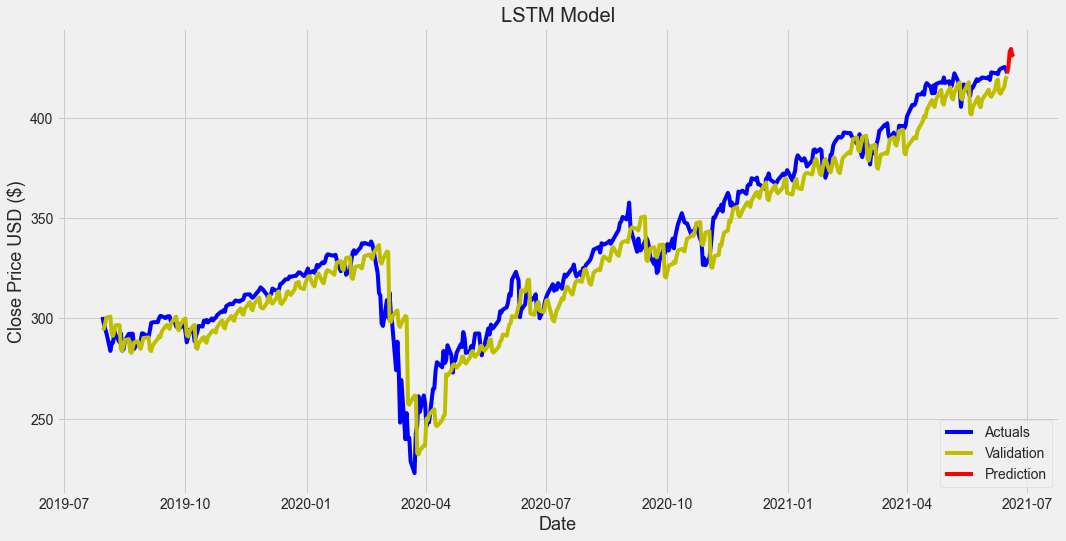

In [30]:
out_path = '/Users/bretonshindel/Desktop/'
#stock_list = ['SPY', 'ARKG', 'LAC', 'IWC']
stock_list = ['SPY']
lag = 5
for stock in stock_list:

    train_data, test_data, X_train, y_train, train_dates, test_dates = data_prep(stock, lag=lag)

    val_model = build_model(X_train, y_train)

    predictions, test_out = performance_model(val_model, train_data, test_data, lag=lag)

    final_pred = full_model(stock, lag)
    
    plot_model(test_out, predictions, final_pred, test_dates[-1], lag=lag)

In [36]:
def full_model(stock, lag):

    df = DataReader(stock, data_source='yahoo', start='2012-01-01', end=datetime.now())
    df_size = len(df) - len(df)%lag
    df = df.tail(df_size)
    df_dates = df.index

    #dataset = scaler.fit_transform(df)
    dataset = df.values
    full_data = np.array(np.split(dataset, len(dataset)/lag))

    data = full_data.reshape((full_data.shape[0]*full_data.shape[1], full_data.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + lag
        out_end = in_end + lag
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 3]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 3])
        # move along one time step
        in_start += 1

    X, y = np.array(X), np.array(y)
    print(X.shape)

    model = build_model(X, y)
    
    flat_data = []
    for i in range(0, len(full_data)):
        for j in range(0, lag):
            flat_data.append(full_data[i][j][3])

    final_batch = np.array(flat_data[-5:]).reshape(1,lag,1)
    yhat = model.predict(final_batch, verbose=1)
    yhat = yhat[0]

    return X, full_data, flat_data, final_batch


X, full_data, flat_data, final_batch = full_model(stock, lag)

(2366, 5, 1)
1/1 [==============================] - 0s 197ms/step


In [35]:
final_batch

array([[[423.60998535],
        [424.30999756],
        [425.26000977],
        [424.48001099],
        [422.10998535]]])

In [32]:
flat_data

[128.02000427246094,
 129.1300048828125,
 129.1999969482422,
 129.50999450683594,
 128.83999633789062,
 129.33999633789062,
 130.77000427246094,
 131.4600067138672,
 131.9499969482422,
 131.61000061035156,
 131.4600067138672,
 132.55999755859375,
 131.8800048828125,
 131.82000732421875,
 131.3699951171875,
 131.32000732421875,
 132.47000122070312,
 132.67999267578125,
 134.5399932861328,
 134.4499969482422,
 134.7899932861328,
 135.19000244140625,
 135.36000061035156,
 134.36000061035156,
 135.36000061035156,
 135.19000244140625,
 134.55999755859375,
 136.0500030517578,
 136.41000366210938,
 136.47000122070312,
 136.02999877929688,
 136.6300048828125,
 136.92999267578125,
 137.16000366210938,
 137.55999755859375,
 137.02000427246094,
 137.72999572753906,
 137.30999755859375,
 136.75,
 134.75,
 135.69000244140625,
 137.0399932861328,
 137.57000732421875,
 137.5800018310547,
 140.05999755859375,
 139.91000366210938,
 140.72000122070312,
 140.3000030517578,
 140.85000610351562,
 140.44000

In [37]:
full_data

array([[[1.28179993e+02, 1.27410004e+02, 1.28000000e+02, 1.28020004e+02,
         9.95302000e+07, 1.06765602e+02],
        [1.29649994e+02, 1.28949997e+02, 1.29389999e+02, 1.29130005e+02,
         1.15282000e+08, 1.07691315e+02],
        [1.29369995e+02, 1.28520004e+02, 1.28729996e+02, 1.29199997e+02,
         1.11540700e+08, 1.07749680e+02],
        [1.29699997e+02, 1.28539993e+02, 1.29570007e+02, 1.29509995e+02,
         1.18983700e+08, 1.08008202e+02],
        [1.29050003e+02, 1.27720001e+02, 1.28639999e+02, 1.28839996e+02,
         1.79836200e+08, 1.07449440e+02]],

       [[1.30320007e+02, 1.28899994e+02, 1.30080002e+02, 1.29339996e+02,
         1.32209200e+08, 1.07866417e+02],
        [1.30839996e+02, 1.29080002e+02, 1.29309998e+02, 1.30770004e+02,
         1.63395200e+08, 1.09059021e+02],
        [1.31570007e+02, 1.30800003e+02, 1.31220001e+02, 1.31460007e+02,
         1.26328900e+08, 1.09634483e+02],
        [1.31949997e+02, 1.30919998e+02, 1.31240005e+02, 1.31949997e+02,
     

In [38]:
X

array([[[128.02000427],
        [129.13000488],
        [129.19999695],
        [129.50999451],
        [128.83999634]],

       [[129.13000488],
        [129.19999695],
        [129.50999451],
        [128.83999634],
        [129.33999634]],

       [[129.19999695],
        [129.50999451],
        [128.83999634],
        [129.33999634],
        [130.77000427]],

       ...,

       [[419.67001343],
        [420.32998657],
        [418.76998901],
        [422.6000061 ],
        [422.19000244]],

       [[420.32998657],
        [418.76998901],
        [422.6000061 ],
        [422.19000244],
        [422.27999878]],

       [[418.76998901],
        [422.6000061 ],
        [422.19000244],
        [422.27999878],
        [421.6499939 ]]])

In [ ]:
# next steps: scale data?
# multivariate model!!!